# Bài tập tại lớp 2
# Neural Network

### Tóm tắt nội dung
Trong bài tập này, các bạn sẽ giải quyết 02 vấn đề trong assignment 1 bằng Neural Network.

## Mục lục
* [1. Hướng Dẫn](#C1)
    * [1.1. Cấu trúc file](#C1_1)
    * [1.2. Sử dụng gradient_check.py ](#C1_2)
* [2. Sử dụng util.py ](#C2)
    * [2.1. Hàm load_npy()](#C2_1)
    * [2.2. Hàm load_list()](#C2_2)
    * [2.3. Hàm save_list()](#C2_3)
    * [2.4. Hàm get_vehicle_data()](#C2_4)
    * [2.5. Hàm read_mnist_gz()](#C2_5)
    * [2.6. Hàm get_mnist_data()](#C2_6)
    * [2.7. Hàm plot_loss()](#C2_7)
    * [2.8. Hàm normalize()](#C2_8)
    * [2.9. Hàm normalize_vehicle()](#C2_9)
    * [2.10. Hàm create_one_hot()](#C2_10)
    * [2.11. Hàm add_one()](#C2_11)
* [3. Hiện thực neural network bằng numpy](#C3)
    * [3.1. Class Layer](#C3_1)
    * [3.2. Class NeuralNet](#C3_2)
    * [3.3. Huấn luyện mô hình](#C3_4)
        * [3.3.1 Lựa chọn thông số](#C3_4_1)
        * [3.3.2 Vehicle Classification](#C3_4_2)
        * [3.3.3 MNIST Classification](#C3_4_3)
* [4. Hiện thực neural network bằng tensorflow](#C4)   
* [5. Kết quả](#C5)
    * [5.1. Vehicle Classification](#C5_1)
    * [5.2. MNIST Classification](#C5_2)

## 1. Hướng dẫn <a id='C1'></a>
Chương này sẽ hướng dẫn những điều cần thiết để hoàn thành bài tập này.

Để có thể hoàn tất bài tập này, các bạn cần nắm rõ những kiến thức sau: 
- Neural Networks - Fully connected networks là gì, nguyên tắc hoạt động
ra sao.
- Giải thuật Feedforward và BackPropagation trong bài toán NN.
- Giải thuật gradient descent - Batch and Mini-batch.
- Regularization để tránh overfitting trong NN.

Bạn có thể tham khảo lại bài giảng của lớp để nắm vững các nội dung này. Ngoài ra, các bạn có thể đặt câu hỏi cho đội ngũ giảng dạy nếu có thắc mắc.

Bài tập này sẽ gồm có hai bài chính:
- Bài 1: phân loại dữ liệu hai lớp dùng neural networks.
- Bài 2: phân loại tập fashion MNIST.

Giải quyết hai bài trên bằng **cả numpy và TensorFlow**.

### 1.1. Cấu trúc file <a id='C1_1'></a>
Bài tập lớn này được đi kèm với các file sau: 
- util.py: cung cấp các hàm để đọc dữ liệu trong thưc mục data thành các
ma trận numpy. Bạn không cần chỉnh sửa file này.
- activation_np.py: các hàm activation cơ bản sẽ cần người học thực thi
- dnn_np.py: cung cấp các hàm dựng sẵn để giải quyết bài 1 và bài 2,
dùng numpy.
- dnn_tf.py: sử dụng Tensorflow để giải quyết bài 1 và 2.
- vehicles.dat: dữ liệu của bài 1.
- /fashion-mnist/*.gz: dữ liệu của bài 2.

### 1.2. Sử dụng gradient_check.py <a id='C1_2'></a>

File này cung cấp các hàm cho bạn kiếm tra tính toán gradient của bạn.

In [1]:
"""gradient_check.py
This file provides functions for you to check your gradient computation
"""

import numpy as np
import pdb


def rel_error(x, y):
    """
    function to determine relative error between expected output results from our actual implementation of a layer
    :param x: expected output, arbitrary shape
    :param y: output from our implementation
    :return:  relative error > 1e-2 means that the result is probably wrong
                             <= e-7, you should be happy
    """
    return np.max(np.abs(x - y)/ np.maximum(1e-8, np.abs(x) + np.abs(y)))


def eval_numerical_gradient(layer,x, df, verbose = True, h = 0.00001):
    """
    a naive implementation of numerical gradient of f at x
    :param f: should be a function that takes a single argument x
    :param x: is the point to evaluate the gradient at
    :param verbose:
    :param h:
    :return:
    """
    fw = layer.forward(x)
    grad = np.zeros_like(layer.w)
    it = np.nditer(layer.w, flags = ['multi_index'], op_flags = ['readwrite'])
    while not it.finished:

        ix = it.multi_index
        oldval = layer.w[ix].copy()
        layer.w[ix] = oldval + h
        fxph  = layer.forward(x) #evaluate f(x+h)
        layer.w[ix] = oldval - h
        fxmh  = layer.forward(x)
        layer.w[ix] = oldval.copy()

        grad[ix] = np.sum((fxph - fxmh)*df)/ (2*h)
        if verbose:
            print(ix, grad[ix])
        it.iternext()
    return grad

## 2. Sử dụng util.py <a id='C2'></a>

Chương này mô tả các feature trong file util.py.

Sử dụng các thư viện sau:

In [2]:
"""
This files helps you read data from data files
"""
import pickle
import gzip
import glob
import numpy as np
import sys

import matplotlib.pyplot as plt
import pdb

### 2.1. Hàm load_npy() <a id='C2_1'></a>

Mục đích: Sử dụng để load numpy data file
- Input: file_name
- Output: obj

In [3]:
def load_npy(file_name):
    """load_npy
    Load numpy data file. This is needed as python 2.7 pickle uses ascii as default encoding method but python 3.x uses utf-8.abs

    :param file_name: npy file path
    
    :return obj: loaded numpy object
    """
    
    if (sys.version_info[0] >= 3):
        obj = np.load(file_name, encoding='latin1')
    elif (sys.version_info[0] >=2):
        obj = np.load(file_name)
    
    return obj

### 2.2. Hàm load_list() <a id='C2_2'></a>

Mục đích: Sử dụng để load 1 list object vào file_name
- Input: file_name
- Output: list_obj

In [4]:
def load_list(file_name):
    """load_list
    Load a list object to file_name.

    :param file_name: string, file name.
    """
    end_of_file = False
    list_obj = [] 
    f = open(file_name, 'rb')
    python_version = sys.version_info[0]
    while (not end_of_file):
        try:
            if (python_version >= 3):
                list_obj.append(pickle.load(f, encoding='latin1'))
            elif (python_version >=2):
                list_obj.append(pickle.load(f))
        except EOFError:
            end_of_file = True
            print("EOF Reached")

    f.close()
    return list_obj 

### 2.3. Hàm save_list() <a id='C2_3'></a>

Mục đích: Sử dụng để save 1 list object vào trong file_name
- Input: list_obj, file_name
- Output: Save data

In [5]:
def save_list(list_obj, file_name):
    """save_list
    Save a list object to file_name
    
    :param list_obj: List of objects to be saved.
    :param file_name: file name.
    """

    f = open(file_name, 'wb')
    for obj in list_obj:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    f.close() 

### 2.4. Hàm get_vehicle_data() <a id='C2_4'></a>

Mục đích: Sử dụng để load vehicle data trong thư mục
- Input: Lấy data trong thư mục
- Output: List của data

In [6]:
def get_vehicle_data():
    """
    Load vehicle data and return it as a list: [train_x, train_y, test_x, test_y]
    """
    print('Reading vehicle data...')
    train_x, train_y, test_x, test_y = load_list('./data/vehicles.dat')
    train_x = np.transpose(train_x, (2,0,1))
    test_x = np.transpose(test_x, (2,0,1)) 

    print('Done reading')
    return train_x, train_y, test_x, test_y

### 2.5. Hàm read_mnist_gz() <a id='C2_5'></a>

Mục đích: Dùng để đọc fashion MNIST data dưới dạng nén
- Input: data_path, offset
- Output: dataset

In [7]:
def read_mnist_gz(data_path, offset):
    with gzip.open(data_path, 'rb') as f:
        dataset = np.frombuffer(f.read(), dtype=np.uint8, offset=offset)

    return dataset

### 2.6. Hàm get_mnist_data() <a id='C2_6'></a>

Mục đích: Dùng để load fashion MNIST data
- Input: sampling_step
- Output: List của data

In [8]:
def get_mnist_data(sampling_step=20):
    print('Reading fashion MNIST data...')
    train_x = read_mnist_gz('./data/fashion-mnist/train-images-idx3-ubyte.gz', 16)
    train_y = read_mnist_gz('./data/fashion-mnist/train-labels-idx1-ubyte.gz', 8)
    test_x = read_mnist_gz('./data/fashion-mnist/t10k-images-idx3-ubyte.gz', 16)
    test_y = read_mnist_gz('./data/fashion-mnist/t10k-labels-idx1-ubyte.gz', 8)
    num_train = len(train_y)
    num_test = len(test_y)

    train_x = train_x.reshape((num_train, 28*28))
    test_x = test_x.reshape((num_test, 28*28))

    val_x = train_x[50000:,:]
    val_y = train_y[50000:]
    train_x = train_x[:50000,:]
    train_y = train_y[:50000]

    train_x = train_x[0::sampling_step,:]
    train_y = train_y[0::sampling_step]
    val_x = val_x[0::sampling_step,:]
    val_y = val_y[0::sampling_step]
    test_x = test_x[0::sampling_step,:]
    test_y = test_y[0::sampling_step]
 
    print("Done reading")
    return train_x.astype(np.float32), train_y, val_x.astype(np.float32), val_y, test_x.astype(np.float32), test_y

### 2.7. Hàm plot_loss() <a id='C2_7'></a>

Mục đích: Hiện thực đồ thị

In [9]:
def plot_loss(loss, fig=1, color='b'):
    plt.figure(fig)
    plt.clf()
    plt.plot(loss, color='b')

### 2.8. Hàm normalize() <a id='C2_8'></a>

Mục đích: Chuẩn hóa
- Input: train_x, val_x, test_x
- Output: train_x, val_x, test_x

In [10]:
def normalize(train_x, val_x, test_x):
    """normalize
    This function computes train mean and standard deviation on all pixels then applying data scaling on train_x, val_x and test_x using these computed values

    :param train_x: train samples, shape=(num_train, num_feature)
    :param val_x: validation samples, shape=(num_val, num_feature)
    :param test_x: test samples, shape=(num_test, num_feature)
    """
    # train_mean and train_std should have the shape of (1, 1)
    train_mean = np.mean(train_x, axis=(0,1), dtype=np.float64, keepdims=True)
    train_std = np.std(train_x, axis=(0,1), dtype=np.float64, keepdims=True)

    train_x = (train_x-train_mean)/train_std
    val_x = (val_x-train_mean)/train_std
    test_x = (test_x-train_mean)/train_std
    return train_x, val_x, test_x

### 2.9. Hàm normalize_vehicle() <a id='C2_9'></a>

Mục đích: Chuẩn hóa dữ liệu vehicles
- Input: train_x, test_x
- Output: train_x, test_x

In [11]:
def normalize_vehicle(train_x, test_x):
    # train_mean and train_std should have the shape of (1, 1)
    train_mean = np.mean(train_x, axis=0, dtype=np.float64, keepdims=True)
    train_std = np.std(train_x, axis=0, dtype=np.float64, keepdims=True)

    train_x = (train_x-train_mean)/train_std
    test_x = (test_x-train_mean)/train_std

    return train_x, test_x

### 2.10. Hàm create_one_hot() <a id='C2_10'></a>

Mục đích: Tạo ma trận one-hot 
- Input: labels, num_k
- Output: eye_mat

In [12]:
def create_one_hot(labels, num_k=10):
    """create_one_hot
    This function creates a one-hot (one-of-k) matrix based on the given labels

    :param labels: list of labels, each label is one of 0, 1, 2,... , num_k - 1
    :param num_k: number of classes we want to classify
    """
    eye_mat = np.eye(num_k)
    return eye_mat[labels, :].astype(np.float32)

### 2.11. Hàm add_one() <a id='C2_11'></a>

- Input: x
- Output: x

In [13]:
def add_one(x):
    """add_one
    
    This function add ones as an additional feature for x
    :param x: input data
    """
    x = np.concatenate((x, np.ones((x.shape[0], 1))), axis=1)
    return x


if __name__ == '__main__':
    get_mnist_data()

Reading fashion MNIST data...
Done reading


## 3. Hiện thực neural network bằng numpy <a id='C3'></a>

### 3.1. Class Layer <a id='C3_1'></a>

In [14]:
class Layer(object):
    def __init__(self, w_shape, activation, reg = 1e-5):
        """__init__

        :param w_shape: create w with shape w_shape using normal distribution
        :param activation: string, indicating which activation function to be used
        """
        
        mean = 0
        std = 1
        self.w = np.random.normal(0, np.sqrt(2./np.sum(w_shape)), w_shape)
        self.activation = activation
        self.reg = reg

    def forward(self, x):
        """forward
        This function compute the output of this layer
        
        :param x: input
        """
        # [TODO 1.2]
        result = np.dot(x, self.w)
        
        # Compute different types of activation
        if (self.activation == 'sigmoid'):
            result = sigmoid(result)
        elif (self.activation == 'relu'):
            result = reLU(result)
        elif (self.activation == 'tanh'):
            result = tanh(result)
        elif (self.activation == 'softmax'):
            result = softmax_minus_max(result)

        self.output = result
        return result

    def backward(self, x, delta_dot_w_prev):
        """backward
        This function compute the gradient of the loss function with respect to the parameter (w) of this layer

        :param x: input of the layer
        :param delta_dot_w_prev: delta^(l+1) dot product with w^(l+1)T, computed from the next layer (in feedforward direction) or previous layer (in backpropagation direction)
        """
        # [TODO 1.2]
        # Compute delta_last factor from the output
        if(self.activation == 'sigmoid'):
            g = self.output.copy() 
            delta = delta_dot_w_prev*sigmoid_grad(g)
            w_grad = (x.T).dot(delta)
        
        elif(self.activation == 'tanh'):
            g = self.output.copy() 
            delta = delta_dot_w_prev*tanh_grad(g)
            w_grad = (x.T).dot(delta)

        elif(self.activation == 'relu'):
            #backprop ReLU nonlinearity here
            g = self.output
            delta = delta_dot_w_prev.copy()
            delta[g <= 0] = 0
            w_grad =  np.dot( x.T, delta)

        # [TODO 1.4] Implement L2 regularization on weights here
        w_grad +=  self.reg*self.w
        return w_grad, delta.copy()

### 3.2. Class NeuralNet <a id='C3_2'></a>

In [16]:
class NeuralNet(object):
    def __init__(self, num_class=2, reg = 1e-5):
        self.layers = []
        self.momentum = []
        self.reg = reg
        self.num_class = num_class
        
    def add_linear_layer(self, w_shape, activation):
        """add_linear_layer

        :param w_shape: create w with shape w_shape using normal distribution
        :param activation: string, indicating which activation function to be used
        """
        if(len(self.layers) != 0):
            if(w_shape[0] != self.layers[-1].w.shape[-1]):
                raise ValueError("Shape does not match between the added layer and previous hidden layer.")

        if(activation == 'sigmoid'):
            self.layers.append(Layer(w_shape, 'sigmoid', self.reg))
        elif(activation == 'relu'):
            self.layers.append(Layer(w_shape, 'relu', self.reg)) 
        elif(activation == 'tanh'):
            self.layers.append(Layer(w_shape, 'tanh', self.reg))
        elif(activation == 'softmax'):
            self.layers.append(Layer(w_shape, 'softmax', self.reg))
        self.momentum.append(np.zeros_like(self.layers[-1].w))


    def forward(self, x):
        """forward

        :param x: input
        """
        all_x = [x]
        for layer in self.layers:
            all_x.append(layer.forward(all_x[-1]))
        
        return all_x


    def compute_loss(self, y, y_hat):
        """compute_loss
        Compute the average cross entropy loss using y (label) and y_hat (predicted class)

        :param y:  the label, the actual class of the samples. e.g. 3-class classification with 9 data samples y = [0 0 0 1 1 1 2 2 2]
        :param y_hat: the propabilities that the given samples belong to class 1
        """

        # [TODO 1.3]
        # Estimating cross entropy loss from y_hat and y 
        correct_log_probs = np.log(y_hat)*y
        data_loss = -np.sum(correct_log_probs)/y.shape[0]

        #estimating regularization loss from all layers
        reg_loss = 0.0
        for i in range(len(self.layers)):
            reg_loss += 0.5*self.reg*np.sum(self.layers[i].w * self.layers[i].w)

        data_loss += reg_loss

        return data_loss
    
    def backward(self, y, all_x):
        """backward

        :param y: the label, the actual class of the samples. e.g. 3-class classification with 9 data samples y = [0 0 0 1 1 1 2 2 2]
        :param all_x: input data and activation from every layer
        """
        
        # [TODO 1.5] Compute delta factor from the output
        # delta = all_x[-1].copy()
        # delta[:, y.astype(int)] -= 1
        # delta /= y.shape[0]
        delta = (all_x[-1].copy() - y) / y.shape[0]
        
        # [TODO 1.5] Compute gradient of the loss function with respect to w of softmax layer, use delta from the output
        grad_last = self.layers[-2].output.T.dot(delta) + self.reg*self.layers[-1].w
        # grad_last = np.dot(all_x[-2].T, delta) + (self.layers[-1].w * self.reg / y.shape[0])

        grad_list = []
        grad_list.append(grad_last)
        
        for i in range(len(self.layers) - 1)[::-1]:
            prev_layer = self.layers[i+1]
            layer = self.layers[i]
            x = all_x[i]
	    # [TODO 1.5] Compute delta_dot_w_prev factor for previous layer (in backpropagation direction)
	    # delta_prev: delta^(l+1), in the start of this loop, delta_prev is also delta^(L) or delta_last
	    # delta_dot_w_prev: delta^(l+1) dot product with w^(l+1)T
            delta_dot_w_prev = delta.dot(prev_layer.w.T)
	    # Use delta_dot_w_prev to compute delta factor for the next layer (in backpropagation direction)
            grad_w, delta = layer.backward(x, delta_dot_w_prev)
            grad_list.append(grad_w.copy())

        grad_list = grad_list[::-1]
        return grad_list
    
    def update_weight(self, grad_list, learning_rate):
        """update_weight
        Update w using the computed gradient

        :param grad: gradient computed from the loss
        :param learning_rate: float, learning rate
        """
        for i in range(len(self.layers)):
            layer = self.layers[i]
            grad = grad_list[i]
            layer.w = layer.w - learning_rate * grad
    
    
    def update_weight_momentum(self, grad_list, learning_rate, momentum_rate):
        """update_weight_momentum
        Update w using SGD with momentum

        :param grad: gradient computed from the loss
        :param learning_rate: float, learning rate
        :param momentum_rate: float, momentum rate
        """
        for i in range(len(self.layers)):
            layer = self.layers[i]
            self.momentum[i] = self.momentum[i]*momentum_rate + learning_rate*grad_list[i]
            layer.w = layer.w - self.momentum[i]

    def predict(self, x_test):
        y_hat = self.forward(x_test)[-1]
        return np.argmax(y_hat, axis=1)

### 3.3. Huấn luyện mô hình <a id='C3_3'></a>

Để điều chỉnh quá trình huấn luyện, bạn có thể thay đổi các thuộc tính của
biến cfg:

- num_epoch: số lượng vòng lặp cho quá trình huấn luyện.
- batch_size: số lượng mẫu trong một batch.
- learning_rate: hệ số học.
- momentum_rate: hệ số động lực γ.
- num_train: số lượng mẫu sẽ dùng để train trong train_x.
- reg: hệ số λ cho regularization.
- visualize: True hoặc False, xác định xem có vẽ đồ thị lúc huấn luyện hay không.
- epochs_to_draw: số epoch cần trải qua để vẽ đồ thị.

### 3.4.1 Lựa chọn thông số <a id='C3_4_1'></a>

- num_epoch: 500 (cho vehicle classification) và 300 (cho MNIST classification)
- batch_size: 100 (cho vehicle classification) và 200 (cho MNIST classification)
- learning_rate: 0.01 (cho vehicle classification) và 0.001 (cho MNIST classification)
- momentum_rate: 0.9
- num_train: train_x.shape
- reg: 0.00015
- visualize: False (cho vehicle classification), False (cho MNIST classification)
- epochs_to_draw: 100 (cho vehicle classification)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from util import *
from activation_np import *
from gradient_check import *
from sklearn.metrics import confusion_matrix
import pdb


class Config(object):
    def __init__(self, num_epoch=1000, batch_size=100, learning_rate=0.0005, momentum_rate=0.9, epochs_to_draw=10, reg=0.00015, num_train=1000, visualize=True):
        self.num_epoch = num_epoch
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.momentum_rate = momentum_rate
        self.epochs_to_draw = epochs_to_draw
        self.reg = reg
        self.num_train = num_train
        self.visualize = visualize

In [23]:
def test(y_hat, test_y):
    """test
    Compute the confusion matrix based on labels and predicted values 

    :param y_hat: predicted probabilites, output of classifier.feed_forward
    :param test_y: test labels
    """
    if (y_hat.ndim == 2):
        y_hat = np.argmax(y_hat, axis=1)
    num_class = np.unique(test_y).size
    confusion_mat = np.zeros((num_class, num_class))

    for i in range(num_class):
        class_i_idx = test_y == i
        num_class_i = np.sum(class_i_idx)
        y_hat_i = y_hat[class_i_idx]
        for j in range(num_class):
            confusion_mat[i,j] = 1.0*np.sum(y_hat_i == j)/num_class_i

    np.set_printoptions(precision=2)
    print('Confusion matrix:')
    print(confusion_mat)
    print('Diagonal values:')
    print(confusion_mat.flatten()[0::(num_class+1)])


def unit_test_layer(your_layer):
    """unit test layer

    This function is used to test layer backward and forward for a random datapoint
    error < 1e-8 - you should be happy
    error > e-3  - probably wrong in your implementation
    """
    # generate a random data point
    x_test = np.random.randn(1, your_layer.w.shape[0])
    layer_sigmoid = Layer(your_layer.w.shape, your_layer.activation, reg = 0.0)

    #randomize the partial derivative of the cost function w.r.t the next layer    
    delta_prev = np.ones((1,your_layer.w.shape[1]))
    
    # evaluate the numerical gradient of the layer
    numerical_grad = eval_numerical_gradient(layer_sigmoid, x_test, delta_prev, False)

    #evaluate the gradient using back propagation algorithm
    layer_sigmoid.forward(x_test)
    w_grad, delta = layer_sigmoid.backward(x_test, delta_prev)

    #print out the relative error
    error = rel_error(w_grad, numerical_grad)
    print("Relative error between numerical grad and function grad is: %e" %error)

def minibatch_train(net, train_x, train_y, cfg):
    """minibatch_train
    Train your neural network using minibatch strategy

    :param net: NeuralNet object
    :param train_x: numpy tensor, train data
    :param train_y: numpy tensor, train label
    :param cfg: Config object
    """
    # [TODO 1.6] Implement mini-batch training
    # convert to (N,1) shape to concatenate with train_x data
    train_y_reshape = train_y.reshape(train_y.shape[0],1)
    
    #Mini-batch gradient descent implementation
    all_data_set = np.concatenate((train_x, train_y_reshape), axis = 1)
    
    all_loss = []
    for e in range(cfg.num_epoch):
        all_data_set_shuffle = np.random.shuffle(all_data_set) 
        mini_batch_data_set = np.array_split(all_data_set, cfg.batch_size, axis = 0)
        total_loss = 0.0
        
        for idx, batch in enumerate(mini_batch_data_set):
            train_batch_y = batch[:, -1].copy()
            train_batch_y = create_one_hot(train_batch_y.astype(int), net.num_class)

            train_batch_x = batch[:, :-1].copy()
             
            all_x = net.forward(train_batch_x)
            y_hat = all_x[-1]
            loss = net.compute_loss(train_batch_y, y_hat)
            if np.isnan(loss):
                raise ValueError("Loss is NaN")
            grads = net.backward(train_batch_y, all_x)
            #net.update_weight(grads, cfg.learning_rate)
            net.update_weight_momentum(grads, cfg.learning_rate, cfg.momentum_rate)
            total_loss += loss

        #printing
        if (cfg.visualize and e % cfg.epochs_to_draw == cfg.epochs_to_draw-1):
            plot_loss(all_loss, 2)
            plt.show()
            plt.pause(0.01)

        print("Epoch %d: loss is %.5f" % (e+1, total_loss/cfg.batch_size))
        all_loss.append(total_loss/cfg.batch_size)

def batch_train(net, train_x, train_y, cfg):
    """batch_train
    Train the neural network using batch SGD

    :param net: NeuralNet object
    :param train_x: numpy tensor, train data
    :param train_y: numpy tensor, train label
    :param cfg: Config object
    """

    train_set_x = train_x[:cfg.num_train].copy()
    train_set_y = train_y[:cfg.num_train].copy()
    train_set_y = create_one_hot(train_set_y.astype(int), net.num_class)
    all_loss = []

    for e in range(cfg.num_epoch):
        all_x = net.forward(train_set_x)
        y_hat = all_x[-1]
        loss = net.compute_loss(train_set_y, y_hat)
        grads = net.backward(train_set_y, all_x)
        net.update_weight(grads, cfg.learning_rate)

        all_loss.append(loss)

        if (e % cfg.epochs_to_draw == cfg.epochs_to_draw-1):
            plot_loss(all_loss, 2)
            plt.show()
            plt.pause(0.01)

        print("Epoch %d: loss is %.5f" % (e+1, loss))

### 3.4.2 Vehicle Classification <a id='C3_4_2'></a>

In [24]:
def vehicle_classification():
    # Load data from file
    # Make sure that vehicles.dat is in data/
    train_x, train_y, test_x, test_y = get_vehicle_data()
    train_x, test_x = normalize_vehicle(train_x, test_x)    

    test_y  = test_y.flatten()
    train_y = train_y.flatten()
    num_class = (np.unique(train_y)).shape[0]

    train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1]*train_x.shape[2]))
    test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1]*test_x.shape[2]))

    # Pad 1 as the third feature of train_x and test_x
    train_x = add_one(train_x) 
    test_x = add_one(test_x)

    # Define hyper-parameters and train-related parameters
    cfg = Config(num_epoch=500, learning_rate=0.01, epochs_to_draw = 100, num_train=train_x.shape[0])

    # Create NN classifier
    num_hidden_nodes = 100
    num_hidden_nodes_2 = 100
    num_hidden_nodes_3 = 100
    net = NeuralNet(num_class, cfg.reg)
    net.add_linear_layer((train_x.shape[1],num_hidden_nodes), 'relu')
    net.add_linear_layer((num_hidden_nodes, num_hidden_nodes_2), 'relu')
    net.add_linear_layer((num_hidden_nodes_2, num_hidden_nodes_3), 'relu')
    net.add_linear_layer((num_hidden_nodes_3, num_class), 'softmax')
    
    batch_train(net, train_x, train_y, cfg)
    
    y_hat = net.forward(test_x)[-1]
    test(y_hat, test_y)

    metrics = confusion_matrix(test_y, net.predict(test_x))
    print("Accuracy: ")
    print(metrics.trace()/test_y.shape[0])

Relative error between numerical grad and function grad is: 1.332183e-09
Reading vehicle data...
EOF Reached
Done reading
Epoch 1: loss is 0.85979
Epoch 2: loss is 0.77041
Epoch 3: loss is 0.70774
Epoch 4: loss is 0.66135
Epoch 5: loss is 0.62571
Epoch 6: loss is 0.59779
Epoch 7: loss is 0.57516
Epoch 8: loss is 0.55655
Epoch 9: loss is 0.54080
Epoch 10: loss is 0.52733
Epoch 11: loss is 0.51557
Epoch 12: loss is 0.50521
Epoch 13: loss is 0.49595
Epoch 14: loss is 0.48756
Epoch 15: loss is 0.47993
Epoch 16: loss is 0.47297
Epoch 17: loss is 0.46655
Epoch 18: loss is 0.46056
Epoch 19: loss is 0.45495
Epoch 20: loss is 0.44970
Epoch 21: loss is 0.44478
Epoch 22: loss is 0.44016
Epoch 23: loss is 0.43578
Epoch 24: loss is 0.43161
Epoch 25: loss is 0.42763
Epoch 26: loss is 0.42382
Epoch 27: loss is 0.42015
Epoch 28: loss is 0.41663
Epoch 29: loss is 0.41324
Epoch 30: loss is 0.40997
Epoch 31: loss is 0.40681
Epoch 32: loss is 0.40374
Epoch 33: loss is 0.40076
Epoch 34: loss is 0.39787
Epo

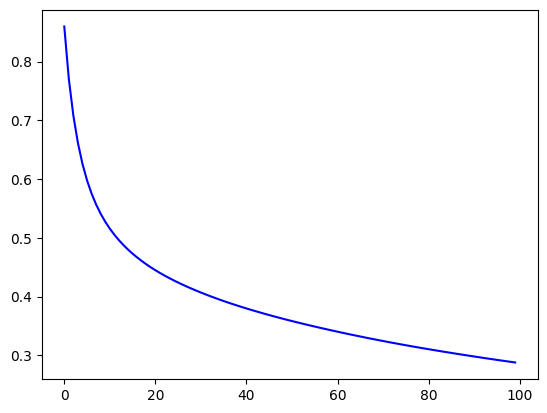

Epoch 100: loss is 0.28770
Epoch 101: loss is 0.28662
Epoch 102: loss is 0.28555
Epoch 103: loss is 0.28449
Epoch 104: loss is 0.28344
Epoch 105: loss is 0.28240
Epoch 106: loss is 0.28136
Epoch 107: loss is 0.28034
Epoch 108: loss is 0.27932
Epoch 109: loss is 0.27831
Epoch 110: loss is 0.27730
Epoch 111: loss is 0.27630
Epoch 112: loss is 0.27532
Epoch 113: loss is 0.27434
Epoch 114: loss is 0.27337
Epoch 115: loss is 0.27241
Epoch 116: loss is 0.27145
Epoch 117: loss is 0.27050
Epoch 118: loss is 0.26955
Epoch 119: loss is 0.26862
Epoch 120: loss is 0.26768
Epoch 121: loss is 0.26676
Epoch 122: loss is 0.26584
Epoch 123: loss is 0.26492
Epoch 124: loss is 0.26401
Epoch 125: loss is 0.26310
Epoch 126: loss is 0.26221
Epoch 127: loss is 0.26131
Epoch 128: loss is 0.26043
Epoch 129: loss is 0.25955
Epoch 130: loss is 0.25868
Epoch 131: loss is 0.25782
Epoch 132: loss is 0.25696
Epoch 133: loss is 0.25611
Epoch 134: loss is 0.25526
Epoch 135: loss is 0.25442
Epoch 136: loss is 0.25357
E

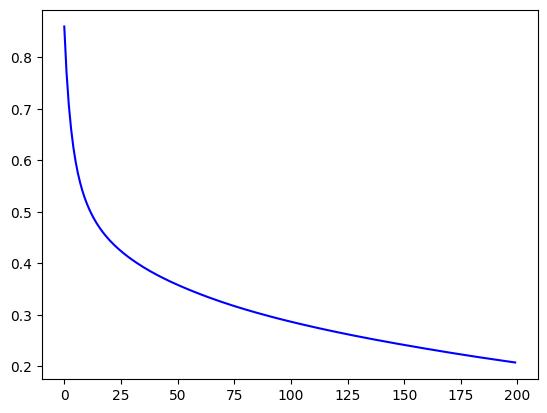

Epoch 200: loss is 0.20748
Epoch 201: loss is 0.20686
Epoch 202: loss is 0.20624
Epoch 203: loss is 0.20563
Epoch 204: loss is 0.20502
Epoch 205: loss is 0.20441
Epoch 206: loss is 0.20380
Epoch 207: loss is 0.20320
Epoch 208: loss is 0.20260
Epoch 209: loss is 0.20200
Epoch 210: loss is 0.20141
Epoch 211: loss is 0.20081
Epoch 212: loss is 0.20022
Epoch 213: loss is 0.19964
Epoch 214: loss is 0.19905
Epoch 215: loss is 0.19847
Epoch 216: loss is 0.19789
Epoch 217: loss is 0.19731
Epoch 218: loss is 0.19673
Epoch 219: loss is 0.19616
Epoch 220: loss is 0.19559
Epoch 221: loss is 0.19502
Epoch 222: loss is 0.19446
Epoch 223: loss is 0.19389
Epoch 224: loss is 0.19333
Epoch 225: loss is 0.19278
Epoch 226: loss is 0.19222
Epoch 227: loss is 0.19166
Epoch 228: loss is 0.19111
Epoch 229: loss is 0.19056
Epoch 230: loss is 0.19001
Epoch 231: loss is 0.18947
Epoch 232: loss is 0.18893
Epoch 233: loss is 0.18838
Epoch 234: loss is 0.18785
Epoch 235: loss is 0.18731
Epoch 236: loss is 0.18677
E

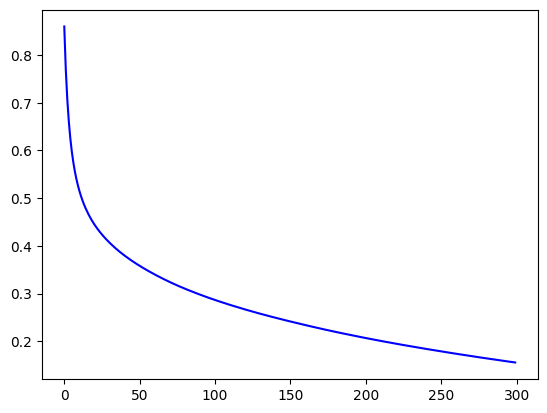

Epoch 300: loss is 0.15571
Epoch 301: loss is 0.15527
Epoch 302: loss is 0.15483
Epoch 303: loss is 0.15440
Epoch 304: loss is 0.15396
Epoch 305: loss is 0.15353
Epoch 306: loss is 0.15310
Epoch 307: loss is 0.15267
Epoch 308: loss is 0.15224
Epoch 309: loss is 0.15182
Epoch 310: loss is 0.15139
Epoch 311: loss is 0.15097
Epoch 312: loss is 0.15055
Epoch 313: loss is 0.15013
Epoch 314: loss is 0.14971
Epoch 315: loss is 0.14929
Epoch 316: loss is 0.14887
Epoch 317: loss is 0.14845
Epoch 318: loss is 0.14804
Epoch 319: loss is 0.14762
Epoch 320: loss is 0.14721
Epoch 321: loss is 0.14680
Epoch 322: loss is 0.14639
Epoch 323: loss is 0.14599
Epoch 324: loss is 0.14558
Epoch 325: loss is 0.14517
Epoch 326: loss is 0.14477
Epoch 327: loss is 0.14436
Epoch 328: loss is 0.14396
Epoch 329: loss is 0.14356
Epoch 330: loss is 0.14316
Epoch 331: loss is 0.14277
Epoch 332: loss is 0.14237
Epoch 333: loss is 0.14198
Epoch 334: loss is 0.14159
Epoch 335: loss is 0.14119
Epoch 336: loss is 0.14080
E

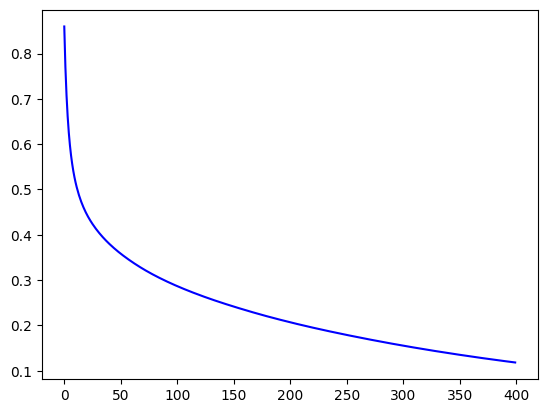

Epoch 400: loss is 0.11819
Epoch 401: loss is 0.11787
Epoch 402: loss is 0.11755
Epoch 403: loss is 0.11724
Epoch 404: loss is 0.11692
Epoch 405: loss is 0.11661
Epoch 406: loss is 0.11630
Epoch 407: loss is 0.11598
Epoch 408: loss is 0.11567
Epoch 409: loss is 0.11536
Epoch 410: loss is 0.11505
Epoch 411: loss is 0.11474
Epoch 412: loss is 0.11443
Epoch 413: loss is 0.11412
Epoch 414: loss is 0.11382
Epoch 415: loss is 0.11351
Epoch 416: loss is 0.11321
Epoch 417: loss is 0.11291
Epoch 418: loss is 0.11261
Epoch 419: loss is 0.11231
Epoch 420: loss is 0.11201
Epoch 421: loss is 0.11171
Epoch 422: loss is 0.11141
Epoch 423: loss is 0.11111
Epoch 424: loss is 0.11082
Epoch 425: loss is 0.11052
Epoch 426: loss is 0.11023
Epoch 427: loss is 0.10994
Epoch 428: loss is 0.10965
Epoch 429: loss is 0.10936
Epoch 430: loss is 0.10907
Epoch 431: loss is 0.10878
Epoch 432: loss is 0.10850
Epoch 433: loss is 0.10821
Epoch 434: loss is 0.10793
Epoch 435: loss is 0.10764
Epoch 436: loss is 0.10736
E

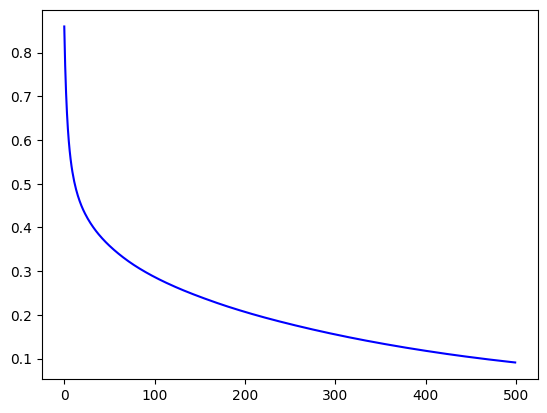

Epoch 500: loss is 0.09120
Confusion matrix:
[[0.82 0.18]
 [0.17 0.83]]
Diagonal values:
[0.82 0.83]
Accuracy: 
0.8216666666666667


In [25]:
if __name__ == '__main__':
    np.random.seed(2017)
    
    #numerical check for your layer feedforward and backpropagation
    your_layer = Layer((60, 100), 'sigmoid')
    unit_test_layer(your_layer)

    plt.ion()
    vehicle_classification()

### 3.4.2 MNIST Classification <a id='C3_4_2'></a>

In [26]:
def mnist_classification():
    # Load data from file
    # Make sure that fashion-mnist/*.gz is in data/
    train_x, train_y, val_x, val_y, test_x, test_y = get_mnist_data(1)
    train_x, val_x, test_x = normalize(train_x, train_x, test_x)    

    num_class = (np.unique(train_y)).shape[0]

    # Pad 1 as the third feature of train_x and test_x
    train_x = add_one(train_x)
    val_x = add_one(val_x)
    test_x = add_one(test_x)

    # Define hyper-parameters and train-related parameters
    cfg = Config(num_epoch=300, learning_rate=0.001, batch_size=200, num_train=train_x.shape, visualize=False)

    # Create NN classifier
    num_hidden_nodes = 100
    num_hidden_nodes_2 = 100
    num_hidden_nodes_3 = 100
    net = NeuralNet(num_class, cfg.reg)
    net.add_linear_layer((train_x.shape[1],num_hidden_nodes), 'relu')
    net.add_linear_layer((num_hidden_nodes, num_hidden_nodes_2), 'relu')
    net.add_linear_layer((num_hidden_nodes_2, num_hidden_nodes_3), 'relu')
    net.add_linear_layer((num_hidden_nodes_3, num_class), 'softmax')
     
    #Minibatch training - training dataset using Minibatch approach
    minibatch_train(net, train_x, train_y, cfg)
    
    y_hat = net.forward(test_x)[-1]
    test(y_hat, test_y)

    metrics = confusion_matrix(test_y, net.predict(test_x))
    print("Accuracy: ")
    print(metrics.trace()/test_y.shape[0])

In [27]:
if __name__ == '__main__':
    np.random.seed(2017)
    
    #numerical check for your layer feedforward and backpropagation
    your_layer = Layer((60, 100), 'sigmoid')
    unit_test_layer(your_layer)

    plt.ion()
    mnist_classification()

Relative error between numerical grad and function grad is: 1.332183e-09
Reading fashion MNIST data...
Done reading
Epoch 1: loss is 1.19781
Epoch 2: loss is 0.67262
Epoch 3: loss is 0.58429
Epoch 4: loss is 0.53838
Epoch 5: loss is 0.50902
Epoch 6: loss is 0.48791
Epoch 7: loss is 0.47126
Epoch 8: loss is 0.45801
Epoch 9: loss is 0.44728
Epoch 10: loss is 0.43808
Epoch 11: loss is 0.42919
Epoch 12: loss is 0.42241
Epoch 13: loss is 0.41563
Epoch 14: loss is 0.40939
Epoch 15: loss is 0.40330
Epoch 16: loss is 0.39797
Epoch 17: loss is 0.39437
Epoch 18: loss is 0.38898
Epoch 19: loss is 0.38455
Epoch 20: loss is 0.38036
Epoch 21: loss is 0.37810
Epoch 22: loss is 0.37389
Epoch 23: loss is 0.36930
Epoch 24: loss is 0.36661
Epoch 25: loss is 0.36261
Epoch 26: loss is 0.35985
Epoch 27: loss is 0.35684
Epoch 28: loss is 0.35387
Epoch 29: loss is 0.35016
Epoch 30: loss is 0.34712
Epoch 31: loss is 0.34526
Epoch 32: loss is 0.34333
Epoch 33: loss is 0.33905
Epoch 34: loss is 0.33674
Epoch 35:

## 4. Hiện thực neural network bằng tensorflow<a id='C4'></a>

In [28]:
import numpy as np
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.enable_eager_execution()
tf.keras.backend.clear_session()
import matplotlib.pyplot as plt
from util import * 
from dnn_np import test
from sklearn.metrics import confusion_matrix
import pdb

Instructions for updating:
non-resource variables are not supported in the long term


#### Tensorflow for Vehicle classification

In [29]:
def vehicle_classification():
    # Load data from file
    # Make sure that bat.dat is in data/
    train_x, train_y, test_x, test_y = get_vehicle_data()
    train_x, test_x = normalize_vehicle(train_x, test_x)    

    test_y  = test_y.flatten().astype(np.int32)
    train_y = train_y.flatten().astype(np.int32)
    num_class = (np.unique(train_y)).shape[0]

    train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1]*train_x.shape[2]))
    test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1]*test_x.shape[2]))
 
    # DNN parameters
    hidden_layers = [100, 100, 100]
    learning_rate = 0.01
    batch_size = 200
    steps = 500
   
    # Specify that all features have real-value data
    feature_columns = [tf.feature_column.numeric_column("x", shape=[train_x.shape[1]])]


    # Available activition functions
    # https://www.tensorflow.org/versions/r0.12/api_docs/python/nn/activation_functions_
    # tf.nn.relu
    # tf.nn.elu
    # tf.nn.sigmoid
    # tf.nn.tanh
    activation = tf.nn.relu
    
    # [TODO 1.7] Create a neural network and train it using estimator

    # Some available gradient descent optimization algorithms
    # https://www.tensorflow.org/api_guides/python/train#Optimizers
    # tf.train.GradientDescentOptimizer
    # tf.train.AdadeltaOptimizer
    # tf.train.AdagradOptimizer
    # tf.train.AdagradDAOptimizer
    # tf.train.MomentumOptimizer
    # tf.train.AdamOptimizer
    # tf.train.FtrlOptimizer
    # tf.train.ProximalGradientDescentOptimizer
    # tf.train.ProximalAdagradOptimizer
    # tf.train.RMSPropOptimizer
    # Create optimizer
    optimizer = tf.train.ProximalAdagradOptimizer(
                                    learning_rate=learning_rate, 
                                    l2_regularization_strength=0.001)

    # optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    # optimizer = tf.train.MomentumOptimizer(learning_rate=0.01, momentum=0.005)
    
    # build a deep neural network
    # https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier
    classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns, 
                                    hidden_units= hidden_layers,
                                    n_classes=num_class,
                                    optimizer= optimizer,
                                    activation_fn= activation,
                                    model_dir="problem1-estimator")
    
    # Define the training inputs
    # https://www.tensorflow.org/api_docs/python/tf/estimator/inputs/numpy_input_fn
    train_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
                                    x={"x": train_x},
                                    y=train_y,
                                    num_epochs=None, # None will run forever.
                                    batch_size = batch_size,
                                    shuffle=True)
    
    # Train model.
    classifier.train(
        input_fn=train_input_fn,
        steps=steps)
    
    # Define the test inputs
    test_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
                                    x={"x": test_x},
                                    y=test_y,
                                    num_epochs=1,
                                    shuffle=False)
    
    # Evaluate accuracy. 
    predict_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
      x={"x": test_x},
      num_epochs=1,
      shuffle=False)

    y_hat = classifier.predict(input_fn=predict_input_fn)
    y_hat = list(y_hat)
    y_hat = np.asarray([int(x['classes'][0]) for x in y_hat]) 
    test(y_hat, test_y)

In [30]:
if __name__ == '__main__':
    np.random.seed(2017) 

    plt.ion()
    vehicle_classification()

Reading vehicle data...
EOF Reached
Done reading
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'problem1-estimator', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Instructions for updating:
U

#### Tensorflow for MNIST classification

In [31]:
def mnist_classification():
    # Load data from file
    # Make sure that fashion-mnist/*.gz is in data/
    train_x, train_y, val_x, val_y, test_x, test_y = get_mnist_data(1)

    train_x, val_x, test_x = normalize(train_x, train_x, test_x)    

    train_y = train_y.flatten().astype(np.int32)
    val_y = val_y.flatten().astype(np.int32)
    test_y = test_y.flatten().astype(np.int32)
    num_class = (np.unique(train_y)).shape[0]
    #pdb.set_trace()

    # DNN parameters
    hidden_layers = [100, 100, 100]
    learning_rate = 0.1
    batch_size = 200
    steps = 500
   
    # Specify that all features have real-value data
    feature_columns = [tf.feature_column.numeric_column("x", shape=[train_x.shape[1]])]


    # Choose activation function
    activation = tf.nn.relu
    
    # Some available gradient descent optimization algorithms 
    # TODO: [YC1.7] Create optimizer
    optimizer = tf.train.ProximalAdagradOptimizer(
                                    learning_rate=learning_rate, 
                                    l2_regularization_strength=0.001)
    
    # build a deep neural network
    classifier = tf.estimator.DNNClassifier(
                                    feature_columns=feature_columns,
                                    hidden_units= hidden_layers,
                                    n_classes=num_class,
                                    optimizer= optimizer,
                                    activation_fn= activation,
                                    model_dir="problem2-estimator") 
    
    # Define the training inputs
    # https://www.tensorflow.org/api_docs/python/tf/estimator/inputs/numpy_input_fn
    train_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
                                    x={"x": train_x},
                                    y=train_y,
                                    num_epochs=None, # None will run forever.
                                    batch_size = batch_size,
                                    shuffle=True)
    
    # Train model.
    classifier.train(
        input_fn=train_input_fn,
        steps=steps)
    
    # Define the test inputs
    test_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
                                    x={"x": test_x},
                                    y=test_y,
                                    num_epochs=1,
                                    shuffle=False)
    
    # Evaluate accuracy. 
    predict_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
      x={"x": test_x},
      num_epochs=1,
      shuffle=False)
    y_hat = classifier.predict(input_fn=predict_input_fn)
    y_hat = list(y_hat)
    y_hat = np.asarray([int(x['classes'][0]) for x in y_hat]) 
    test(y_hat, test_y)

In [33]:
if __name__ == '__main__':
    np.random.seed(2017) 

    plt.ion()
    mnist_classification()

Reading fashion MNIST data...
Done reading
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'problem2-estimator', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
IN

## 5 Kết quả <a id='C5'></a>

### 5.1. Vehicle Classification <a id='*C5_1*'></a>

#### Numpy:
- Epoch 500: loss is 0.09120
- Confusion matrix:
$$\begin{bmatrix} 0.82 & 0.18 \\ 0.17 & 0.83 \end{bmatrix}$$
- Diagonal values:
 $$\begin{bmatrix} 0.82 & 0.83 \end{bmatrix}$$
- Accuracy: 
0.8216666666666667

#### Tensorflow:
- INFO:tensorflow:Loss for final step: 0.09103702.
- Confusion matrix:
$$\begin{bmatrix} 0.8 & 0.2 \\ 0.16 & 0.84 \end{bmatrix}$$
- Diagonal values:
$$\begin{bmatrix} 0.8 & 0.84 \end{bmatrix}$$
- Accuracy: 0.82

Kết quả khi sử dụng numpy có vẻ ổn định và chính xác hơn khi sử dụng Tensorflow

### 5.2. MNIST Classification <a id='*C5_2*'></a>

#### Numpy:
- Epoch 300: loss is 0.07380
- Confusion matrix:
$$\begin{bmatrix} 0.79 & 0.01 & 0.03 & 0.02 & 0.01 & 0. & 0.14 & 0. & 0.01 & 0. 
    \\ 0. & 0.97 & 0. & 0.02 & 0.01 & 0. & 0. & 0. & 0. & 0.
    \\ 0.02 & 0.01 & 0.79 & 0.01 & 0.1 & 0. & 0.07 0. & 0. & 0.
    \\ 0.03 & 0.02 & 0.01 & 0.86 & 0.03 & 0. & 0.04 & 0. & 0.01 & 0.
    \\ 0. & 0. & 0.1 & 0.03 & 0.79 & 0. & 0.07 & 0. & 0.01 & 0.
    \\ 0. & 0. & 0. & 0. & 0. & 0.96 & 0. & 0.02 & 0.01 & 0.01
    \\ 0.11 & 0. & 0.08 & 0.02 & 0.06 & 0. & 0.7 & 0. & 0.01 & 0.
    \\ 0. & 0. & 0. & 0. & 0. & 0.02 & 0. & 0.95 & 0. & 0.03
    \\ 0.01 & 0. & 0. & 0. & 0. & 0. & 0.02 & 0. & 0.96 & 0.
    \\ 0. & 0. & 0. & 0. & 0. & 0.01 & 0. & 0.04 & 0. & 0.95
    \end{bmatrix}$$
- Diagonal values:
$$\begin{bmatrix} 0.79 & 0.97 & 0.79 & 0.86 & 0.79 & 0.96 & 0.7 & 0.95 & 0.96 & 0.95 \end{bmatrix}$$
- Accuracy: 
0.8735
#### Tensorflow:
- INFO:tensorflow:Loss for final step: 66.0305.
- Confusion matrix:
 $$\begin{bmatrix} 0.77 & 0. & 0.02 & 0.08 & 0. & 0. & 0.12 & 0. & 0.01 & 0. 
    \\ 0. & 0.96 & 0. & 0.03 & 0.01 & 0. & 0. & 0. & 0. & 0.
    \\ 0.01 & 0. & 0.82 & 0.02 & 0.1 & 0. & 0.05 & 0. & 0.01 & 0.
    \\ 0.01 & 0.01 & 0.01 & 0.9 & 0.04 & 0. & 0.02 & 0. & 0.01 & 0.
    \\ 0. & 0. & 0.15 & 0.04 & 0.76 & 0. & 0.04 & 0. & 0. & 0.
    \\ 0. & 0. & 0. & 0. & 0. & 0.93 & 0. & 0.04 & 0.01 & 0.02
    \\ 0.12 & 0. & 0.13 & 0.06 & 0.08 & 0. & 0.59 & 0. & 0.01 & 0.
    \\ 0. & 0. & 0. & 0. & 0. & 0.02 & 0. & 0.96 & 0. & 0.02
    \\ 0. & 0. & 0. & 0.01 & 0.01 & 0. & 0.01 & 0. & 0.97 & 0.
    \\ 0. & 0. & 0. & 0. & 0. & 0. & 0. & 0.06 & 0. & 0.94
    \end{bmatrix}$$
- Diagonal values:
$$\begin{bmatrix} 0.77 & 0.96 & 0.82 & 0.9 & 0.76 & 0.93 & 0.59 & 0.96 & 0.97 & 0.94 \end{bmatrix}$$
- Accuracy: 0.86

Kết quả khi sử dụng numpy có vẻ ổn định và chính xác hơn khi sử dụng Tensorflow